#### Audio Classification Data Preprocessing

In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.preprocessing import normalize
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import models, layers
import tensorflow as tf
import gc

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16296842877729579202
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2814010911802771469
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5054471872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4048190357405335159
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:07:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16254965798185655132
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
df=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
df.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [5]:
#Calculate the average length of each audio file
df['length']=df['end']-df['start']

In [6]:
df=df.loc[df['length']>3.0]

In [7]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,length
1,100263-2-0-117.wav,100263,58.5,62.5,1,5,2,children_playing,4.0
2,100263-2-0-121.wav,100263,60.5,64.5,1,5,2,children_playing,4.0
3,100263-2-0-126.wav,100263,63.0,67.0,1,5,2,children_playing,4.0
4,100263-2-0-137.wav,100263,68.5,72.5,1,5,2,children_playing,4.0
5,100263-2-0-143.wav,100263,71.5,75.5,1,5,2,children_playing,4.0


In [8]:
#Resample the dataframe to reduce memory load in training
df=df.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=0.25))
df['class'].value_counts()

street_music        250
air_conditioner     249
children_playing    245
engine_idling       243
siren               225
jackhammer          210
drilling            208
dog_bark            174
car_horn             54
gun_shot              8
Name: class, dtype: int64

In [9]:
df=df.reset_index()
df.drop(['index'],axis=1,inplace=True)
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,length
0,83502-0-0-9.wav,83502,4.5,8.5,2,10,0,air_conditioner,4.0
1,165454-0-0-7.wav,165454,3.5,7.5,1,9,0,air_conditioner,4.0
2,134717-0-0-12.wav,134717,6.0,10.0,1,1,0,air_conditioner,4.0
3,167464-0-0-10.wav,167464,5.0,9.0,2,10,0,air_conditioner,4.0
4,167464-0-0-18.wav,167464,9.0,13.0,2,10,0,air_conditioner,4.0


[-0.00292552  0.00104841  0.00231299 ...  0.00327135  0.00556787
  0.00308065]
22050


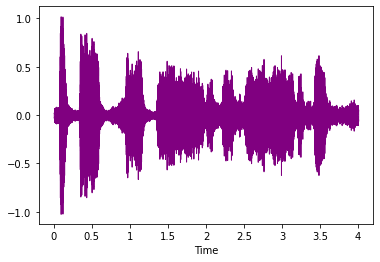

In [10]:
sample_num=300#pick a file to display
filename=df.slice_file_name[sample_num]
#define the times of the signal
tstart = df.start[sample_num] 
tend = df.end[sample_num] #define the end time of the signal
path='UbranSound8K/audio/fold'+str(df.fold[sample_num])+str('/'+filename)
librosa_audio_data,librosa_sample_rate=librosa.load(path) #load the file
print(librosa_audio_data)
print(librosa_sample_rate)
librosa.display.waveshow(librosa_audio_data,sr=librosa_sample_rate, x_axis='time', color='purple')
ipd.Audio(librosa_audio_data,rate=librosa_sample_rate)

In [11]:
librosa_audio_data.shape

(88200,)

### A point to be noted, here is that I tested the sample rates for multiple audio files and it seems all of them have a S.R of 22050. Also, each file is 4s long on average. So the number of MFCC's extracted is approx between 172 and 173

#### Observation
Scipy wav reads a file as stereo,unlike librosa

In [12]:
### Lets read with scipy
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(path) 

In [13]:
wave_audio

array([[-150, -148],
       [ -73,  -70],
       [  74,   80],
       ...,
       [ 160,  157],
       [  98,  100],
       [  95,   98]], dtype=int16)

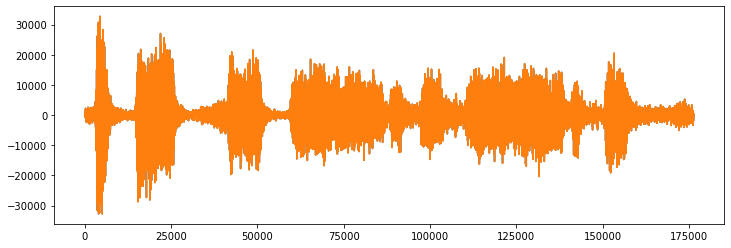

In [14]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

### Just going to extract multiple features for experimentation, before that, define a padding function to make sure that each feature axis has the same dimensionality

In [15]:
#Padding code picked up from stackoverflow, Nicolas Gervais 
#https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

### Examples of feature extraction

In [16]:
print(librosa.feature.zero_crossing_rate(librosa_audio_data))

[[0.04199219 0.06494141 0.10693359 0.14160156 0.17236328 0.19726562
  0.19238281 0.17675781 0.15380859 0.14257812 0.13232422 0.12060547
  0.10888672 0.09863281 0.11669922 0.13183594 0.15527344 0.17675781
  0.18115234 0.1875     0.1953125  0.19775391 0.19482422 0.19433594
  0.18212891 0.16699219 0.15673828 0.14892578 0.14404297 0.14013672
  0.13085938 0.12109375 0.11376953 0.10742188 0.10742188 0.10449219
  0.10302734 0.10546875 0.10791016 0.10742188 0.12988281 0.15039062
  0.16796875 0.18066406 0.17382812 0.16992188 0.15820312 0.15380859
  0.15576172 0.14550781 0.14355469 0.13476562 0.12207031 0.12011719
  0.12402344 0.12060547 0.11865234 0.11279297 0.10742188 0.11376953
  0.12353516 0.12548828 0.11572266 0.11035156 0.10205078 0.10107422
  0.10644531 0.10791016 0.10205078 0.09472656 0.09716797 0.08837891
  0.09423828 0.09912109 0.09960938 0.11279297 0.11865234 0.12548828
  0.12792969 0.13183594 0.13427734 0.13232422 0.13037109 0.12646484
  0.12255859 0.11132812 0.10742188 0.10253906 0.

In [17]:
mfccs = padding(librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_fft=128, hop_length=128,n_mfcc=345),1,1)
print(mfccs)
print(mfccs.shape)

[[-659.0835    -625.91174   -640.6179    ... -645.45575   -636.4322
  -661.6428   ]
 [ -36.8014     -52.639423   -52.7133    ...  -17.582233   -16.920721
   -16.38919  ]
 [ -37.419544   -23.397236   -10.937935  ...  -51.520184   -50.530754
   -43.703117 ]
 ...
 [  -2.8123064   -4.532509    -7.3330326 ...   -2.5583744   -4.0903416
    -4.864771 ]
 [  -7.1086473   -4.2335005   -1.3066001 ...   -8.367489    -5.330982
    -5.2097263]
 [   5.0597897    2.8146553    0.9335213 ...    6.3138194    3.6810284
     3.9017997]]
(128, 690)


[[2.35542417e-01 4.64298844e-01 1.08190536e+00 ... 2.44695759e+00
  8.62360775e-01 5.70605457e-01]
 [1.81785867e-01 1.01970625e+00 1.13137949e+00 ... 1.52401972e+00
  1.09254456e+00 5.27385890e-01]
 [1.00148022e-01 3.83283317e-01 5.50934732e-01 ... 8.27500671e-02
  8.23445559e-01 3.90729904e-01]
 ...
 [3.37640522e-04 4.23677033e-04 4.99648566e-04 ... 1.51237444e-04
  1.14412855e-04 1.93917006e-03]
 [4.83216689e-04 1.02972648e-04 3.53213181e-05 ... 5.96217615e-05
  2.63890433e-05 1.75454980e-03]
 [4.86255653e-04 1.87921396e-05 2.88330029e-05 ... 3.72562645e-05
  1.92019870e-05 1.69344351e-03]]
(65, 690)


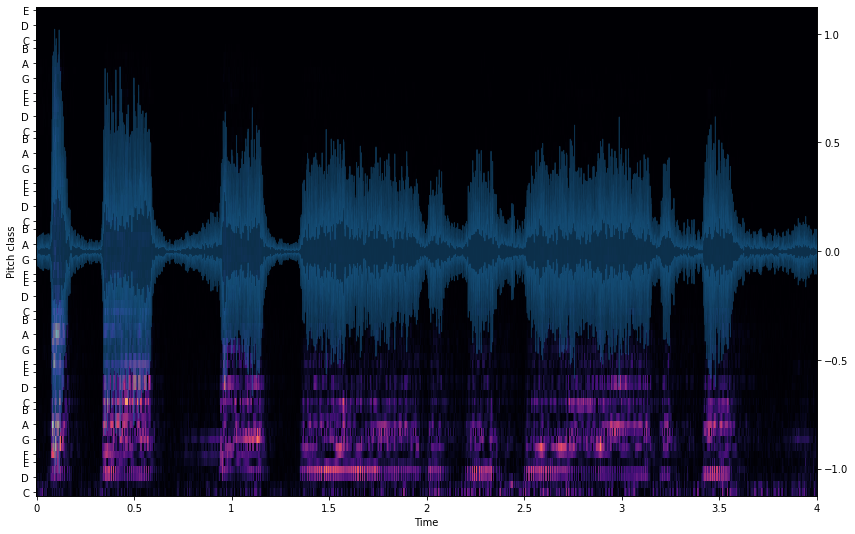

In [18]:
stft = padding(np.abs(librosa.stft(librosa_audio_data, n_fft=128, hop_length= 128)), 18, 1)
print(stft)
print(stft.shape)
fig = plt.figure(figsize=(14, 9))
ax1 = fig.subplots()
ax2 = ax1.twinx()

librosa.display.specshow(stft, x_axis='time', y_axis='chroma', ax=ax1,n_fft=128, hop_length= 128)
librosa.display.waveshow(librosa_audio_data, sr=librosa_sample_rate, ax=ax2,alpha=0.4)
plt.show()

In [19]:
#Defined a custom normalizer to visualize spectral centroids against the waveform
def normalizer(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)*0.4

(173,)


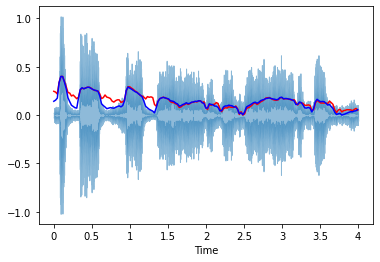

In [20]:
spec_centroid = librosa.feature.spectral_centroid(librosa_audio_data, sr=librosa_sample_rate)[0]
spec_centroid_corrected = librosa.feature.spectral_centroid(librosa_audio_data+0.08, sr=librosa_sample_rate)[0]
print(spec_centroid_corrected.shape) #1,173
librosa.display.waveshow(librosa_audio_data, sr=librosa_sample_rate,alpha=0.5)
frames = range(len(spec_centroid))
t=librosa.frames_to_time(frames)
plt.plot(t,normalizer(spec_centroid), color='r')
plt.plot(t,normalizer(spec_centroid_corrected), color='b')
plt.show()

#TThe blue line seems to be more tolerant to sudden dips. Hence we will add 0.08 into the spectral centroid plot

(12, 690)


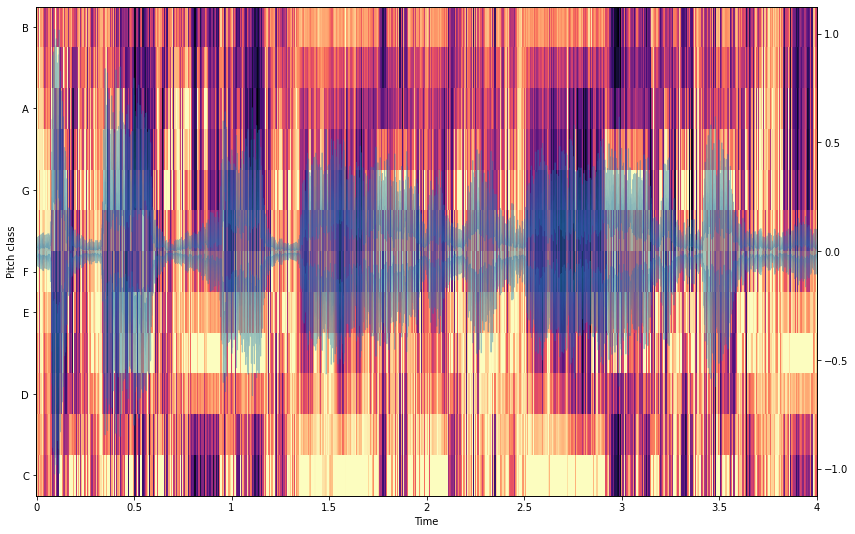

In [21]:
chroma_stft=librosa.feature.chroma_stft(y=librosa_audio_data, sr=librosa_sample_rate, n_fft=128, hop_length= 128)
print(chroma_stft.shape)
fig = plt.figure(figsize=(14, 9))
ax1 = fig.subplots()
ax2 = ax1.twinx()
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', ax=ax1, n_fft=128, hop_length= 128)
librosa.display.waveshow(librosa_audio_data, sr=librosa_sample_rate, ax=ax2,alpha=0.4)
plt.show()

(2, 173)


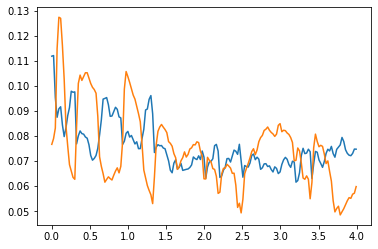

In [22]:
#What would spec_bw and centroid together look like?
spec_centroid_corrected = librosa.feature.spectral_centroid(librosa_audio_data+0.08, sr=librosa_sample_rate)
spec_bw=librosa.feature.spectral_bandwidth(librosa_audio_data, sr=librosa_sample_rate,centroid=spec_centroid_corrected)
image = np.array(normalize(spec_bw))
image = np.append(image,normalize(spec_centroid_corrected), axis=0)
print(image.shape)
frames = range(len(spec_bw[0]))
t=librosa.frames_to_time(frames)
plt.plot(t,np.transpose(image))

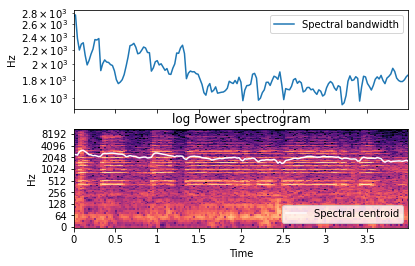

In [23]:
S, phase = librosa.magphase(librosa.stft(y=librosa_audio_data))
sr=librosa_sample_rate
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(spec_bw)
centroid = librosa.feature.spectral_centroid(S=S)
spec_bw=librosa.feature.spectral_bandwidth(librosa_audio_data, sr=librosa_sample_rate)
ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
# ax[1].fill_between(t, np.maximum(0, spec_centroid - spec_bw),
#                 np.minimum(centroid[0] + spec_bw[0], sr/2),
#                 alpha=0.5, label='Centroid +- bandwidth')
ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')

### It does seem especially important to merge all this features along the Z axis so that they show a better depiction

# Actual feature extraction

### It might make sense to depth stack our earlier observed features so that our model can utilize all 4 of them

In [24]:
sr=22050
def generate_features(y_cut):
    max_size=690 #an attempt to conserve computing resources
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=128, hop_length= 128)), 128, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=128, hop_length=128,n_mfcc=690),128,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut+0.08, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr, n_fft=128, hop_length= 128)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr,centroid=spec_centroid)
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),1, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image
    

In [25]:
data=generate_features(librosa_audio_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


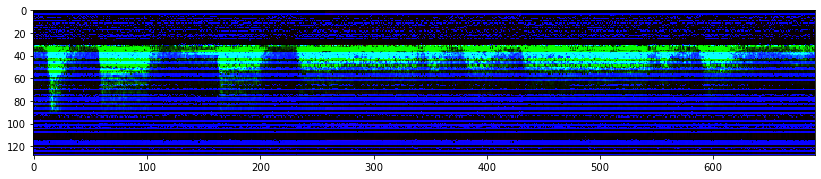

In [26]:
#Spec-bw,centroid and chroma padded and repeated
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 25))
plt.imshow(data, interpolation='nearest')
plt.show()

In [27]:
import cv2
data_reshape=cv2.resize(data,(256,256))
data_reshape.shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


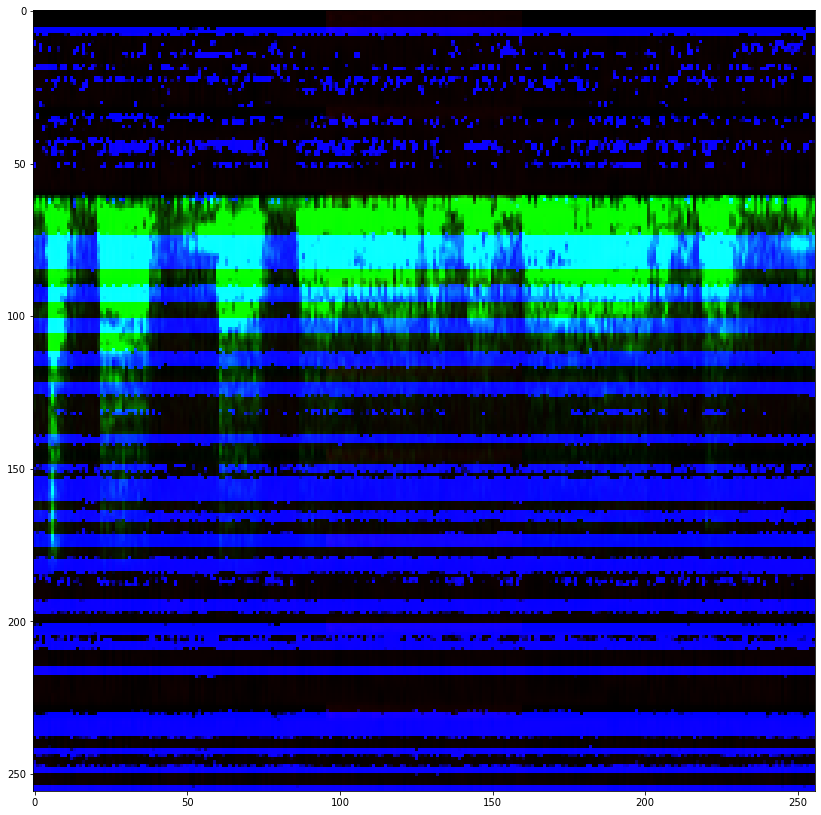

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 25))
plt.imshow(data_reshape, interpolation='nearest')
plt.show()

### Let's just get the above stated features for each audio file

In [29]:
def get_features(df_in):
    output=[]
    labels = []
    for i in df_in['class'].unique():
        print('class:',i)     #all the file indices with the same species_id     
        filelist = df_in.loc[df['class']==i].index         
        for j in range(0,len(filelist)):             
            filename = df_in.iloc[filelist[j]].slice_file_name #get the filename   
            #define the timestamps of the signal          
            fold = df_in.iloc[filelist[j]].fold
            length=df_in.iloc[filelist[j]].length
            class_id=i
            #Load the file
            y, sr = librosa.load('UrbanSound8K/audio/fold'+str(str(fold)+str('/'+filename)))  
            #cut the file to signal start and end  
            y_cut=y[int(round(0*sr)):int(3*sr)]  
            #generate features & output numpy array          
            data = generate_features(y_cut) 
            labels.append(class_id)  
            output.append(data)
    return(output, labels)

In [30]:
# audio_dataset_path='UrbanSound8K/audio/'
# from tqdm import tqdm
# ### Now we iterate through every audio file and extract features 
# extracted_features=[]
# for index_num,row in tqdm(df.iterrows()):
#     #Get filename
#     file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
#     #Get label
#     final_class_labels=row["class"]
#     #Define timestamps
#     tstart = row['start']
#     tend = row['end'] 
#     length=row['length']
#     #Load the file
#     y, sr = librosa.load(file_name) 
#     #cut the file to signal start and end  
#     y_cut=librosa_audio_data[int(round(0*sr)):int(round(length*sr))]
#     #Generate features
#     data=generate_features(y_cut)
#     #Create a dual list to store feature and labels
#     extracted_features.append([data,final_class_labels])

In [31]:
# ### converting extracted_features to Pandas dataframe
# df_ext=pd.DataFrame(extracted_features,columns=['feature','labels'])
# df_ext.head()

In [32]:
# plt.figure(figsize=(14, 25))
# plt.imshow(df_ext['feature'][250], interpolation='nearest')
# plt.show()

In [33]:
#Now we can pass the appropriate dataframe and get the said features
extracted_features_list,extracted_labels_list=get_features(df)

class: air_conditioner
class: car_horn
class: children_playing
class: dog_bark
class: drilling
class: engine_idling
class: gun_shot
class: jackhammer
class: siren
class: street_music


In [34]:
#Resize function to resize the images
import cv2
def resize(image):
    image=cv2.resize(image,(256,256))
    return image

In [35]:
output_features_list=list(map(resize,extracted_features_list))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


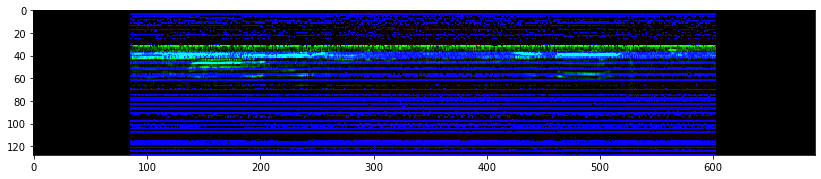

In [36]:
output_features_list[10].shape
plt.figure(figsize=(14, 25))
plt.imshow(extracted_features_list[530], interpolation='nearest')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


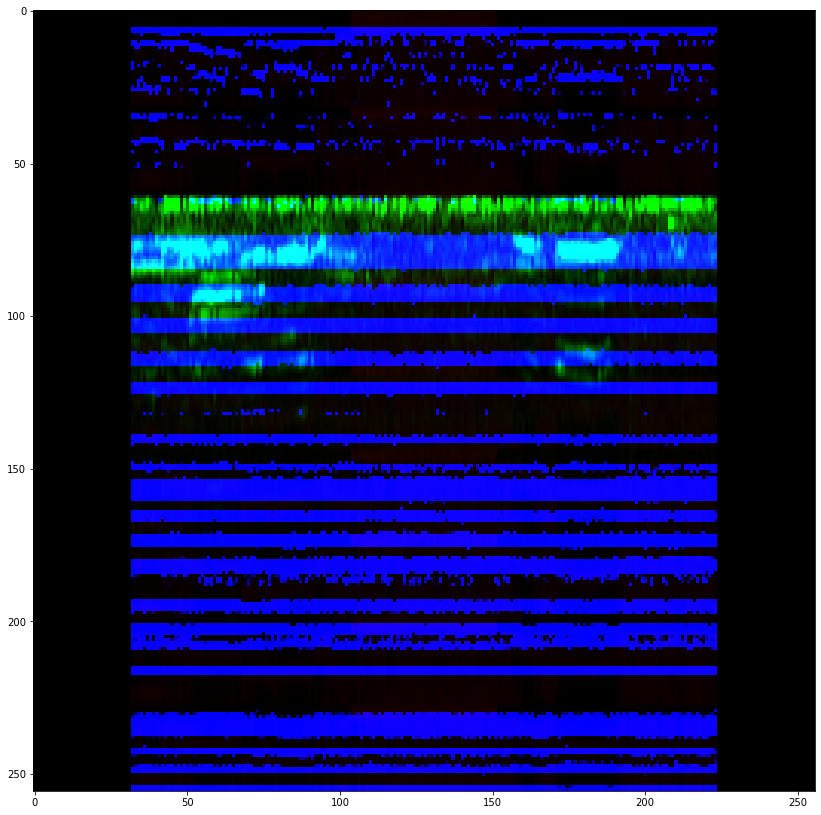

In [37]:
output_features_list[10].shape
plt.figure(figsize=(14, 25))
plt.imshow(output_features_list[530], interpolation='nearest')
plt.show()

In [38]:
# extracted_features_list=output_features_list

In [39]:
df_ext=pd.DataFrame(columns=['feature','labels'])

In [40]:
df_ext['feature']=extracted_features_list
df_ext['labels']=extracted_labels_list

In [41]:
df_ext.head()

,feature,labels
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",air_conditioner
1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",air_conditioner
2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",air_conditioner
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",air_conditioner
4,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",air_conditioner


In [42]:
#Clear the list variables to save memory
del extracted_features_list
del extracted_labels_list
del output_features_list
gc.collect()

15961

In [43]:
### Split the dataset into independent and dependent dataset
X=np.array(df_ext['feature'].tolist())
y=np.array(df_ext['labels'].tolist())

In [44]:
#Destruct the new dataframe variable()
del df_ext
gc.collect()

0

In [45]:
X.shape

(1866, 128, 690, 3)

In [46]:
y.shape

(1866,)

### Final frontier before training, convert the class feature into labels

In [47]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
y.shape

(1866, 10)

In [48]:
### Train Test Split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)

In [49]:
X_train.shape

(1492, 128, 690, 3)

In [50]:
y_train.shape

(1492, 10)

In [51]:
X_test.shape

(374, 128, 690, 3)

In [52]:
y_test.shape

(374, 10)

In [53]:
#Destruct the X array to declutter
del X
gc.collect()

0

In [54]:
X_train.min()

-1108.28125

# CNN


In [55]:
#Data normalization
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_test = np.array((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)))
X_train = X_train/np.std(X_train)
X_test = X_test/np.std(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [56]:
# del model
# gc.collect()
# keras.backend.clear_session()

In [57]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3(input_shape=(128,690,3), include_top = False, weights = 'imagenet')

In [58]:
#Freeze the final layer
for layer in model.layers:
    layer.trainable = False

In [59]:
#Extralayer 1
x = layers.Flatten()(model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Extralayer 2
x = layers.Dense(32, activation='relu')(x)

#Final layer
x = layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(model.input, x)

In [60]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 690, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 344, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 344, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 344, 32)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [61]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_CNN.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 21.8509 - accuracy: 0.1180
Epoch 00001: val_loss improved from inf to 2.29554, saving model to saved_models\audio_CNN.hdf5
47/47 [==============================] - 68s 1s/step - loss: 21.8509 - accuracy: 0.1180 - val_loss: 2.2955 - val_accuracy: 0.1096
Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 2.2904 - accuracy: 0.1119
Epoch 00002: val_loss improved from 2.29554 to 2.28732, saving model to saved_models\audio_CNN.hdf5
47/47 [==============================] - 47s 1s/step - loss: 2.2904 - accuracy: 0.1119 - val_loss: 2.2873 - val_accuracy: 0.1096
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 2.2817 - accuracy: 0.1193
Epoch 00003: val_loss improved from 2.28732 to 2.27965, saving model to saved_models\audio_CNN.hdf5
47/47 [==============================] - 48s 1s/step - loss: 2.2817 - accuracy: 0.1193 - val_loss: 2.2796 - val_accuracy: 0.1203
Epoch 4/100
47/47 [===========

KeyboardInterrupt: 

In [ ]:
# keras.backend.clear_session()
# input_shape=(128,690,3)
# CNNmodel = models.Sequential()
# #First layer
# CNNmodel.add(layers.Conv2D(32, (2,2), activation='relu',padding='same',input_shape=input_shape))
# CNNmodel.add(layers.MaxPooling2D(pool_size=(2,2)))
# CNNmodel.add(layers.Dropout(0.2))
# #Second layer
# CNNmodel.add(layers.Conv2D(64, (2,2),padding='same',activation='relu'))
# CNNmodel.add(layers.MaxPooling2D(pool_size=(2,2)))
# CNNmodel.add(layers.Dropout(0.2))
# #Third layer
# CNNmodel.add(layers.Conv2D(32, (2,2),padding='same', activation='relu'))
# CNNmodel.add(layers.MaxPooling2D(pool_size=(2,2)))

# CNNmodel.add(layers.Flatten())

# #Fourth layer
# CNNmodel.add(layers.Dense(256, activation='relu'))
# CNNmodel.add(layers.Dropout(0.2))
# #Fifth layer
# CNNmodel.add(layers.Dense(32, activation='relu'))
# #Final layer
# CNNmodel.add(layers.Dense(10, activation='softmax'))

In [ ]:
CNNmodel.summary()

In [ ]:
CNNmodel.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_CNN.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

CNNmodel.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
# CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
CNNmodel.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
history = CNNmodel.fit(X_train, y_train, epochs=20, validation_data= (X_val, y_val))